In [128]:
import pandas as pd
import numpy as np
import random
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [129]:
dataset = pd.read_csv('final.csv')
dataset

,Unnamed: 0,Name,gender,Age,StudentID,ethnicity,parental education,lunch,test preparation course,math score,reading score,writing score
0,0,Mark Dodd,female,28,10000,group B,bachelor's degree,standard,none,72,72,74
1,1,Tony Meola,female,26,10001,group C,some college,standard,completed,69,90,88
2,2,Mark Dougherty,female,25,10002,group B,master's degree,standard,none,90,95,93
3,3,Jorge Campos,male,20,10003,group A,associate's degree,free/reduced,none,47,57,44
4,4,Garth Lagerwey,male,25,10004,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,Luis Robles,female,28,10995,group E,master's degree,standard,completed,88,99,95
996,996,Zack Steffen,male,20,10996,group C,high school,free/reduced,none,62,55,55
997,997,Bobby Shuttleworth,female,19,10997,group C,high school,free/reduced,completed,59,71,65
998,998,Stefan Frei,female,22,10998,group D,some college,standard,completed,68,78,77


In [130]:
def avgSensitivity(attribute):
    genAvg = np.average(attribute)
    dataArr = np.array(attribute)
    
    avgs = []
    for i in range(len(dataArr)):
        newAvg = np.average(np.delete(dataArr,i))
        avgs.append(newAvg)
    
    firstFlag = 0
    for avg in avgs:
        if firstFlag == 0:
            maxDiff = abs(genAvg - avg)
            firstFlag = 1
        else:
            maxi = abs(genAvg - avg)
            if maxi > maxDiff:
                maxDiff = maxi
    return maxDiff

In [131]:
def stdSensitivity(attribute):
    genAvg = np.std(attribute)
    dataArr = np.array(attribute)
    
    stds = []
    for i in range(len(dataArr)):   
        newStd = np.std(np.delete(dataArr,i))
        stds.append(newStd)
    
    firstFlag = 0
    for avg in stds:
        if firstFlag == 0:
            maxDiff = abs(genAvg - avg)
            firstFlag = 1
        else:
            maxi = abs(genAvg - avg)
            if maxi > maxDiff:
                maxDiff = maxi
    return maxDiff

In [132]:
maxDiffMathScoreAvg = avgSensitivity(dataset["math score"])
maxDiffMathScoreStd = stdSensitivity(dataset["math score"])

maxDiffReadScoreAvg = avgSensitivity(dataset["reading score"])
maxDiffReadScoreStd = stdSensitivity(dataset["reading score"])

maxDiffWriteScoreAvg = avgSensitivity(dataset["writing score"])
maxDiffWriteScoreStd = stdSensitivity(dataset["writing score"])

originalDiff = [maxDiffMathScoreAvg,maxDiffMathScoreStd,
                maxDiffReadScoreAvg,maxDiffReadScoreStd,
                maxDiffWriteScoreAvg, maxDiffWriteScoreStd]

sensitivityData = pd.DataFrame(index = ["original","0.01","0.2","ln(2)","ln(3)"],
                                columns = ["math score avg","math score std", "reading score avg","reading score std","writing score avg","writing score std"])

sensitivityData.loc["original"] = originalDiff

sensitivityData

,math score avg,math score std,reading score avg,reading score std,writing score avg,writing score std
original,0.066155,0.137424,0.052221,0.08639,0.058112,0.103927
0.01,NaN,NaN,NaN,NaN,NaN,NaN
0.2,NaN,NaN,NaN,NaN,NaN,NaN
ln(2),NaN,NaN,NaN,NaN,NaN,NaN
ln(3),NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
def diffPriv(dataset,columnName,querySensitivity,epsilon):
    col = np.array(dataset[columnName])
    dataset.drop(columns=[columnName])
    laplaceVal = np.random.laplace(0,querySensitivity/epsilon,len(col))
    for i in range(len(col)):
        col[i] += laplaceVal[i]
    dataset[columnName] = col

In [134]:
#So para comparação

def diff_priv(dataset, column, delta_f, epsilon):
    valores_laplace = np.random.laplace(0, delta_f/epsilon, 1000)
    coluna = dataset[column]
    dataset.drop(columns=[column])
    for i, value in enumerate(valores_laplace):
        coluna[i] += value
    dataset[column] = coluna

ale = dataset.copy()
diff_priv(ale,"math score",sensitivityData.loc["original"]["math score avg"],0.2)
maxDiff = avgSensitivity(ale["math score"])
print(maxDiff)

<ipython-input-134-54fac068a6d5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coluna[i] += value


0.06568168168168143


In [135]:
epsilons = {'0.01':0.01,'0.2':0.2,'ln(2)': np.log(2),'ln(3)': np.log(3)}
attributes = ['math score','reading score','writing score']

for attr in attributes:
    for key,value in epsilons.items():
        attributeDataAvg = dataset.copy()
        attributeDataStd = dataset.copy()

        diffPriv(attributeDataAvg,attr,sensitivityData.loc["original"][attr + ' avg'],value)
        diffPriv(attributeDataStd,attr,sensitivityData.loc["original"][attr + ' std'],value)

        newSensivityAvg = avgSensitivity(attributeDataAvg[attr])
        newSensivityStd = stdSensitivity(attributeDataStd[attr])
        sensitivityData.loc[key][attr +' avg'] = newSensivityAvg
        sensitivityData.loc[key][attr +' std'] = newSensivityStd

sensitivityData


,math score avg,math score std,reading score avg,reading score std,writing score avg,writing score std
original,0.066155,0.137424,0.052221,0.08639,0.058112,0.103927
0.01,0.069161,0.248984,0.060004,0.126221,0.065499,0.21639
0.2,0.065639,0.135117,0.051687,0.087855,0.057603,0.105814
ln(2),0.065671,0.135177,0.052711,0.084674,0.058623,0.105762
ln(3),0.065688,0.135036,0.05271,0.084551,0.058615,0.105982


In [136]:
def plotSensAnalysis(x,title, avg,std):
    plt.figure(figsize=(12, 7))

    plt.grid(True)
    plt.title("Sensitivity of " + title, fontsize='x-large')
    plt.ylabel("Sensitivity", fontsize='x-large')
    plt.xlabel("Epsilon value", fontsize='x-large')
    
    plt.scatter(x, avg, color='blue')
    plt.scatter(x, std, color='red')
    
    plt.plot(x, avg, label="Evolution of avg (original, 0.01, 0.2, ln(2), ln(3))", color='blue')
    plt.plot(x, std, label="Evolution of std (original, 0.01, 0.2, ln(2), ln(3))", color='red')
    
    plt.legend()
    
    plt.show()

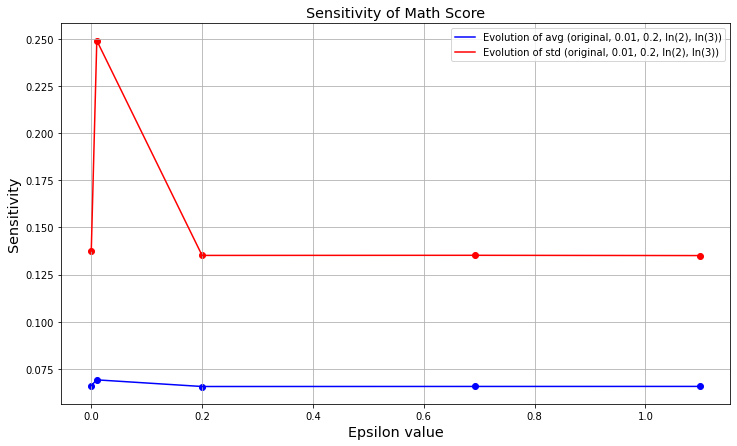

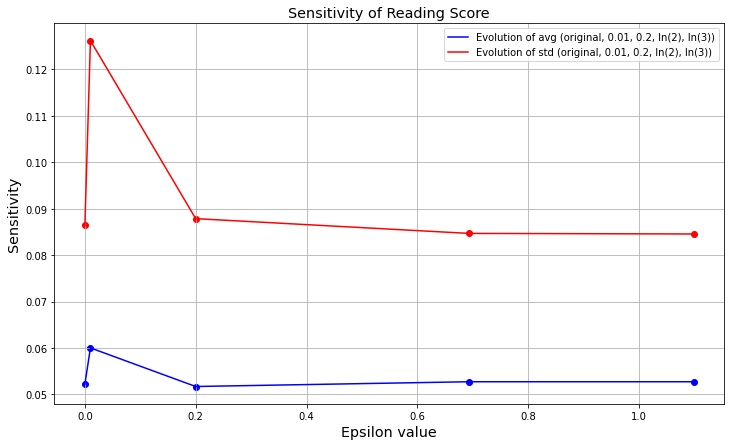

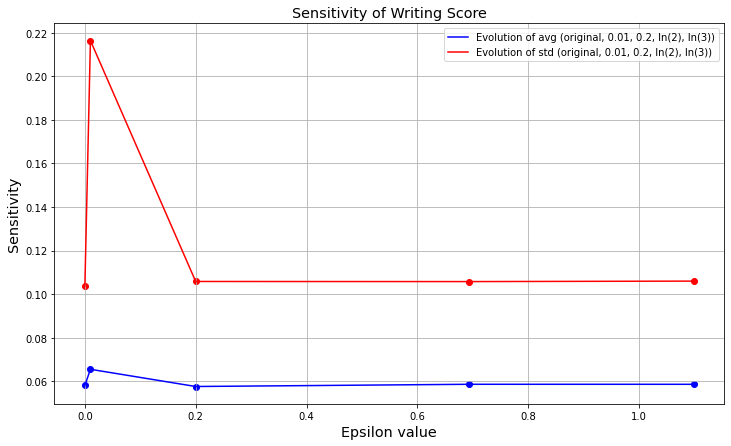

In [137]:
x = [0,0.01,0.2,np.log(2),np.log(3)]
plotSensAnalysis(x,"Math Score",sensitivityData['math score avg'],sensitivityData['math score std'])
plotSensAnalysis(x,"Reading Score",sensitivityData['reading score avg'],sensitivityData['reading score std'])
plotSensAnalysis(x,"Writing Score",sensitivityData['writing score avg'],sensitivityData['writing score std'])

In [138]:
def plotGroupAnalysis(title,xLabel,yLabel,x,plotDatas):
    plt.figure()
    plt.subplots(2, 2, figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.grid(True)
    plt.title(title)
    plt.ylabel(yLabel)
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['0.01'], color='green')
    plt.scatter(x,plotDatas['0.01'], label="Epsilon 0.01", color='green')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.grid(True)
    plt.title("Comparison between mean values of income per year grouped by age")
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['0.2'], color='yellow')
    plt.scatter(x, plotDatas['0.2'], label="Epsilon 0.2", color='yellow')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.grid(True)
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['ln(2)'], color='blue')
    plt.scatter(x, plotDatas['ln(2)'], label="Epsilon ln(2)", color='blue')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.grid(True)
    plt.xlabel(xLabel)
    plt.plot(x, plotDatas['original'], color='red')
    plt.scatter(x, plotDatas['original'], color='red', label="Original values")
    plt.plot(x, plotDatas['ln(3)'], color='orange')
    plt.scatter(x,  plotDatas['ln(3)'], label="Epsilon ln(3)", color='orange')
    plt.legend()
    plt.show()

In [139]:
def groupDiffPriv(group,queryType):
    if queryType == 'avg':
        datasetGroup = dataset.groupby(group).mean()[['math score','reading score','writing score']]
    else:
        datasetGroup = dataset.groupby(group).std()[['math score','reading score','writing score']]
        
    dataset0_0_1 = datasetGroup.copy()
    dataset0_2 = datasetGroup.copy()
    datasetln_2  = datasetGroup.copy()
    datasetln_3 = datasetGroup.copy()

    diffPriv(dataset0_0_1,'math score',sensitivityData.loc['0.01']['math score ' + queryType],0.01)
    diffPriv(dataset0_2,'math score',sensitivityData.loc['0.2']['math score ' + queryType],0.2)
    diffPriv(datasetln_2,'math score',sensitivityData.loc['ln(2)']['math score ' + queryType],np.log(2))
    diffPriv(datasetln_3,'math score',sensitivityData.loc['ln(3)']['math score ' + queryType],np.log(3))

    diffPriv(dataset0_0_1,'reading score',sensitivityData.loc['0.01']['reading score '+queryType],0.01)
    diffPriv(dataset0_2, 'reading score',sensitivityData.loc['0.2']['reading score '+queryType],0.2)
    diffPriv(datasetln_2, 'reading score',sensitivityData.loc['ln(2)']['reading score '+queryType],np.log(2))
    diffPriv(datasetln_3, 'reading score',sensitivityData.loc['ln(3)']['reading score '+queryType],np.log(3))

    diffPriv(dataset0_0_1,'writing score',sensitivityData.loc['0.01']['writing score '+queryType],0.01)
    diffPriv(dataset0_2,'writing score',sensitivityData.loc['0.2']['writing score '+queryType],0.2)
    diffPriv(datasetln_2,'writing score',sensitivityData.loc['ln(2)']['writing score '+ queryType],np.log(2))
    diffPriv(datasetln_3,'writing score',sensitivityData.loc['ln(3)']['writing score '+queryType],np.log(3))
    
    if queryType == 'avg':
        dataset0_0_1 = dataset0_0_1.groupby(group).mean()[['math score','reading score','writing score']]
        dataset0_2 = dataset0_2.groupby(group).mean()[['math score','reading score','writing score']]
        datasetln_2 = datasetln_2.groupby(group).mean()[['math score','reading score','writing score']]
        datasetln_3 = datasetln_3.groupby(group).mean()[['math score','reading score','writing score']]
    else:
        dataset0_0_1 = dataset0_0_1.groupby(group).std()[['math score','reading score','writing score']]
        dataset0_2 = dataset0_2.groupby(group).std()[['math score','reading score','writing score']]
        datasetln_2 = datasetln_2.groupby(group).std()[['math score','reading score','writing score']]
        datasetln_3 = datasetln_3.groupby(group).std()[['math score','reading score','writing score']]
    
    return datasetGroup,dataset0_0_1,dataset0_2,datasetln_2,datasetln_3

In [140]:
group = 'Age'
xLabel = group
x = np.sort(dataset[group].unique())
datasetAvgAge,datasetAvgAge0_0_1,datasetAvgAge0_2,datasetAvgAgeln_2,datasetAvgAgeln_3 = groupDiffPriv(group,'avg')

<Figure size 432x288 with 0 Axes>

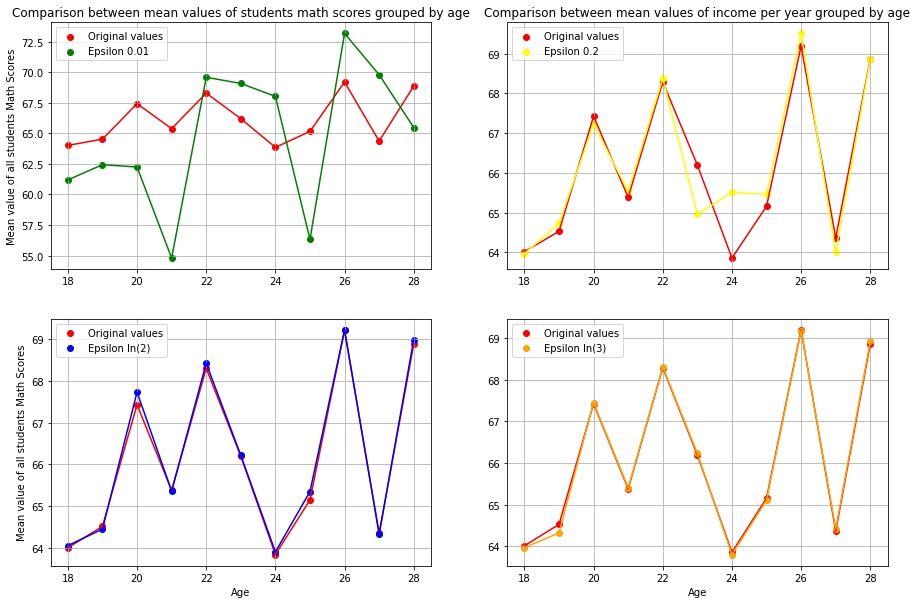

In [141]:
att = 'math score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of all students Math Scores"
title = "Comparison between mean values of students math scores grouped by age"

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas)


<Figure size 432x288 with 0 Axes>

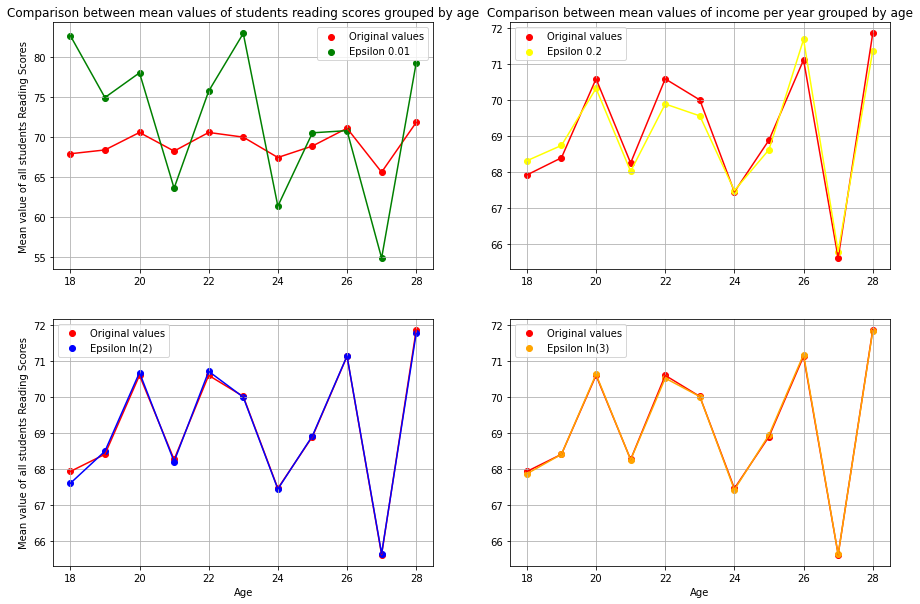

In [142]:
att = 'reading score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of all students Reading Scores"
title = "Comparison between mean values of students reading scores grouped by age"

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas)

<Figure size 432x288 with 0 Axes>

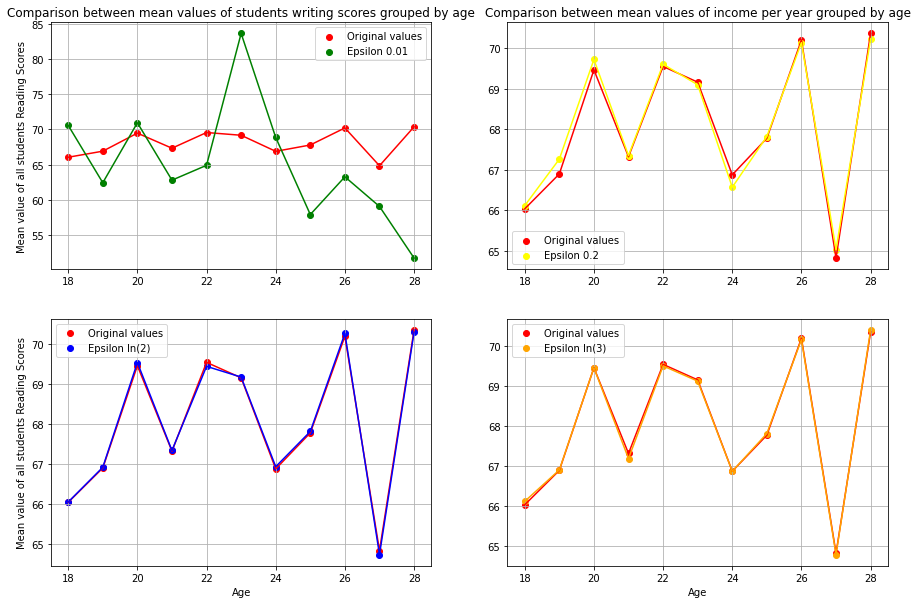

In [143]:
att = 'writing score'

plotDatas = {'original': datasetAvgAge[att],'0.01': datasetAvgAge0_0_1[att],
                '0.2':datasetAvgAge0_2[att],'ln(2)':datasetAvgAgeln_2[att],'ln(3)':datasetAvgAgeln_3[att]}

yLabel = "Mean value of all students Reading Scores"
title = "Comparison between mean values of students writing scores grouped by age"

plotGroupAnalysis(title,xLabel,yLabel,x, plotDatas)